# Final Text Complexity Analysis

## Setup and Preparation

In [1]:
# import anything necessary

import warnings
import pandas as pd
import numpy as np

# for plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

# for clustering
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

In [2]:
# read in data
data = pd.read_csv("/kaggle/input/final-text-complexity-css-rp/gender_bias_toxicity_complexity.csv", low_memory=False)

In [3]:
print([col for col in data.columns])

['id', 'body', 'subreddit', 'Names', 'sex', 'ethnicity', 'Valence', 'Arousal', 'Dominance', 'nr_sentences', 'nr_words', 'nr_characters', 'nr_letters', 'nr_syllables', 'nr_words_one_syllable', 'nr_words_more_syllables', 'tokens', 'nr_unique_words', 'share_unique words', 'nr_swear_words', 'share_swear_words', 'Gunning_Fog', 'gender_dummy', 'leia', 'sentiment', 'sentiment_prob', 'valence', 'arousal', 'dominance', 'nd_valence', 'nd_arousal', 'nd_dominance', 'insult', 'profanity', 'threat', 'severe_toxicity', 'identity_attack', 'toxicity']


**Set style for any plots**

In [4]:
sns.set(style="whitegrid")
sns.set_context("talk", font_scale=1.1)

**Define bootstrapping funtion for error bars**

Given that we work on a relatively small sample when comparing it to the size of the entire dataset, bootstrapping will be applied to any descriptive statistics. 

In [5]:
def bootstrap_mean_ci(data, num_bootstrap=1000, ci=95):
    means = np.zeros(num_bootstrap)
    n = len(data)
    
    # draw per default 1000 samples with replacement
    for i in range(num_bootstrap):
        sample = np.random.choice(data, n, replace=True)
        means[i] = np.mean(sample)
    
    # calculate lower and upper CI bounds
    lower_bound = np.percentile(means, (100 - ci) / 2)
    upper_bound = np.percentile(means, 100 - (100 - ci) / 2)
    
    return np.mean(means), lower_bound, upper_bound

# Visualize results and Preinspection of Gunning-Fog, TTR and Use of Swear Words over Subreddit by Gender

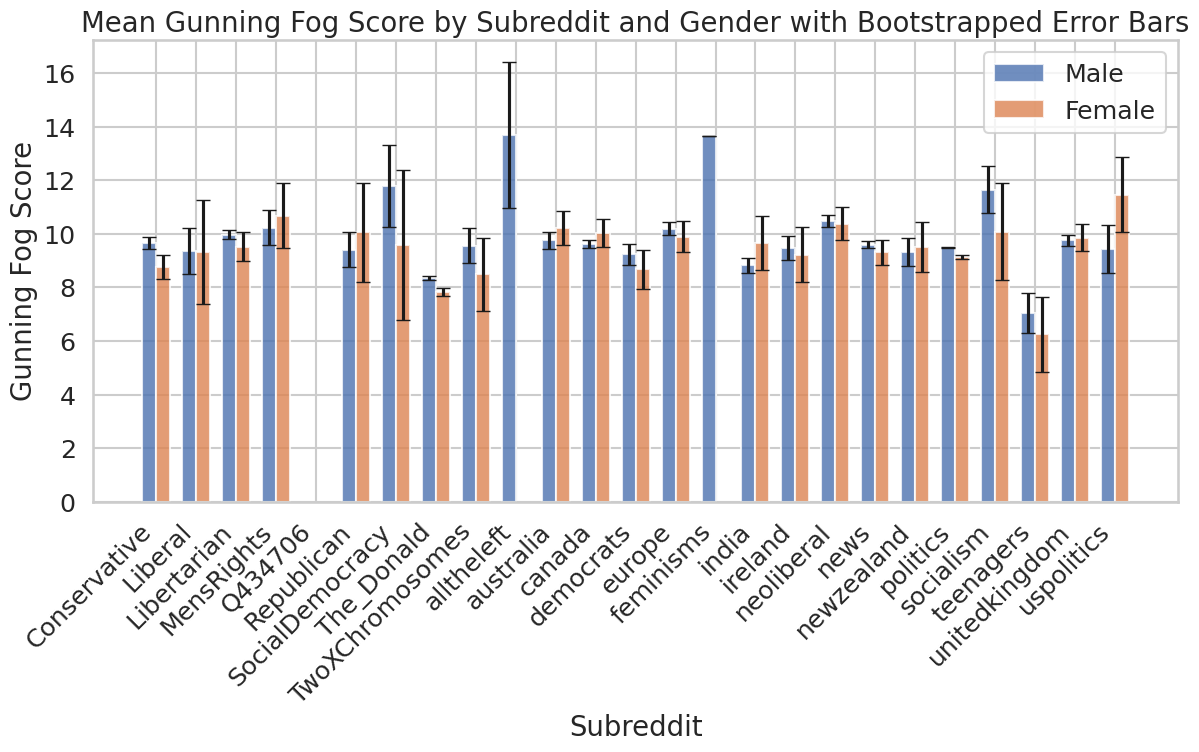

In [6]:
# group by subreddit and gender
grouped = data.groupby(['subreddit', 'sex'])['Gunning_Fog'].apply(
    lambda x: bootstrap_mean_ci(x)).reset_index()

# obtain mean and confidence interval per group
grouped[['mean', 'ci_lower', 'ci_upper']] = pd.DataFrame(grouped['Gunning_Fog'].tolist(), index=grouped.index)
grouped.drop('Gunning_Fog', axis=1, inplace=True)

# then pivot data for plotting
pivoted_mean = grouped.pivot(index='subreddit', columns='sex', values='mean')
pivoted_ci_lower = grouped.pivot(index='subreddit', columns='sex', values='ci_lower')
pivoted_ci_upper = grouped.pivot(index='subreddit', columns='sex', values='ci_upper')

# use pivoted means for error bar computation
errors = pivoted_mean - pivoted_ci_lower

# set plot dimensions
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(pivoted_mean))
width = 0.35

# plot bars for gender == male
ax.bar(x - width/2, pivoted_mean['male'], width, yerr=errors['male'], label='Male', capsize=5, alpha=0.8)

# plot bars for gender == female
ax.bar(x + width/2, pivoted_mean['female'], width, yerr=errors['female'], label='Female', capsize=5, alpha=0.8)

# set labels and title
ax.set_xlabel('Subreddit')
ax.set_ylabel('Gunning Fog Score')
ax.set_title('Mean Gunning Fog Score by Subreddit and Gender with Bootstrapped Error Bars')
ax.set_xticks(x)
ax.set_xticklabels(pivoted_mean.index, rotation=45, ha='right')

ax.legend()

plt.savefig('Gunning_Fog_Subreddit_gender.png', bbox_inches='tight')

plt.show()

While there is no direct pattern in Gunning-Fog Score distribution, a few subreddits stand out for high average Scores: 'SocialDemocracy' (when discussing men), 'alltheleft' (discussing men only), 'feminisms' (discussing men only). The subreddit 'teenagers' stands out for having the lowest average Gunning Fog index displayed across both genders in their posts.

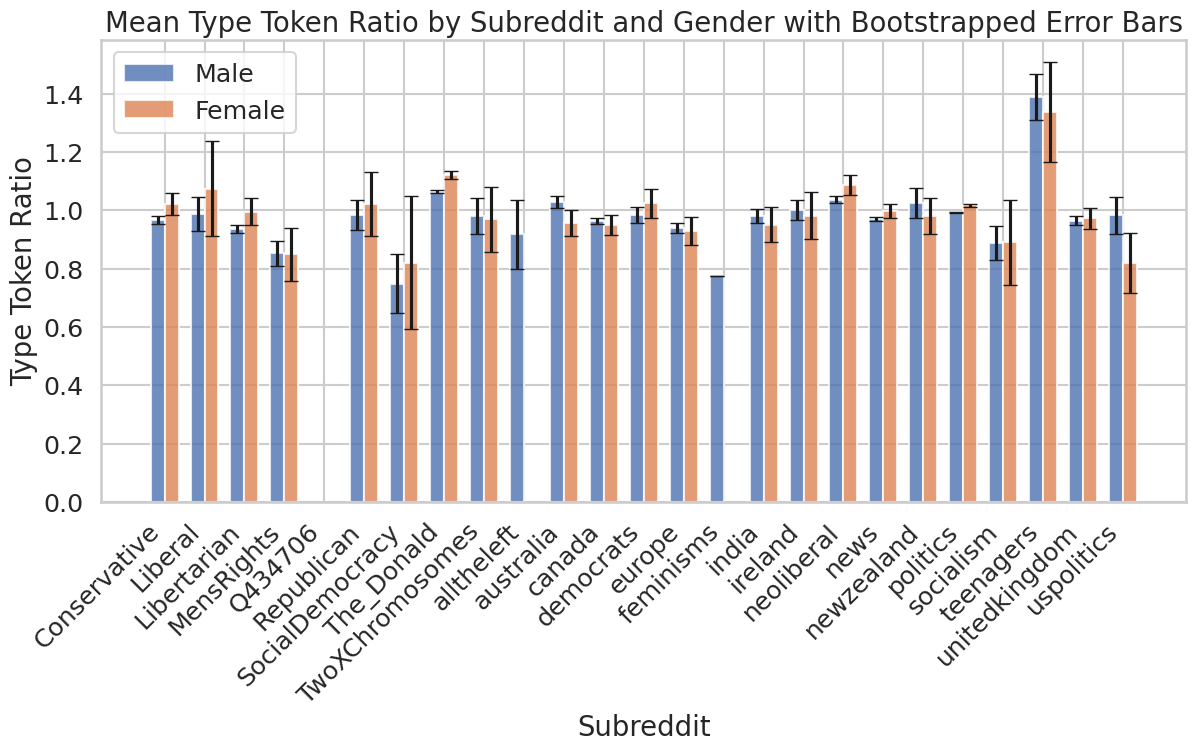

In [7]:
# group data again
grouped = data.groupby(['subreddit', 'sex'])['share_unique words'].apply(
    lambda x: bootstrap_mean_ci(x)).reset_index()

# obtain mean and confidence interval per group
grouped[['mean', 'ci_lower', 'ci_upper']] = pd.DataFrame(grouped['share_unique words'].tolist(), index=grouped.index)
grouped.drop('share_unique words', axis=1, inplace=True)

# then pivot data for plotting
pivoted_mean = grouped.pivot(index='subreddit', columns='sex', values='mean')
pivoted_ci_lower = grouped.pivot(index='subreddit', columns='sex', values='ci_lower')
pivoted_ci_upper = grouped.pivot(index='subreddit', columns='sex', values='ci_upper')

# error bars
errors = pivoted_mean - pivoted_ci_lower
errors = errors.abs()  # Ensure errors are non-negative

# set plot dimensions
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(pivoted_mean))
width = 0.35

# plot bars for gender == male
ax.bar(x - width/2, pivoted_mean['male'], width, yerr=errors['male'], label='Male', capsize=5, alpha=0.8)

# plot bars for gender == female
ax.bar(x + width/2, pivoted_mean['female'], width, yerr=errors['female'], label='Female', capsize=5, alpha=0.8)

# set labels and title
ax.set_xlabel('Subreddit')
ax.set_ylabel('Type Token Ratio')
ax.set_title('Mean Type Token Ratio by Subreddit and Gender with Bootstrapped Error Bars')
ax.set_xticks(x)
ax.set_xticklabels(pivoted_mean.index, rotation=45, ha='right')

ax.legend()

plt.savefig('TTR_Subreddit_gender.png', bbox_inches='tight')

plt.show()

There appears to be no strong pattern in type token ratio (share of unique words) across subreddits, apart from the subreddit 'teenagers' showing the highest averages of type token ratio across both posts directed at men and women.

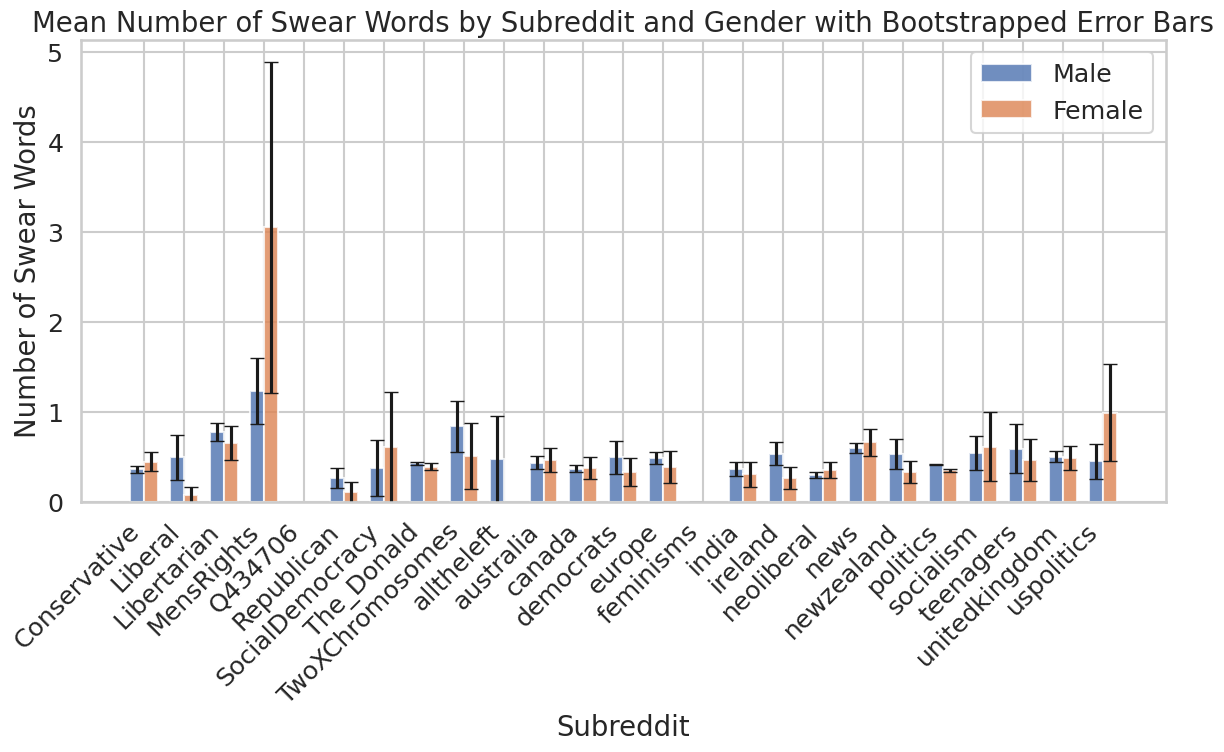

In [8]:
# group data again
grouped = data.groupby(['subreddit', 'sex'])['nr_swear_words'].apply(
    lambda x: bootstrap_mean_ci(x)).reset_index()

# obtain mean and confidence interval per group
grouped[['mean', 'ci_lower', 'ci_upper']] = pd.DataFrame(grouped['nr_swear_words'].tolist(), index=grouped.index)
grouped.drop('nr_swear_words', axis=1, inplace=True)

# then pivot data for plotting
pivoted_mean = grouped.pivot(index='subreddit', columns='sex', values='mean')
pivoted_ci_lower = grouped.pivot(index='subreddit', columns='sex', values='ci_lower')
pivoted_ci_upper = grouped.pivot(index='subreddit', columns='sex', values='ci_upper')

# error bars
errors = pivoted_mean - pivoted_ci_lower
errors = errors.abs()  # Ensure errors are non-negative

# plot
fig, ax = plt.subplots(figsize=(14, 6))
x = np.arange(len(pivoted_mean))
width = 0.35

# plot bars for gender == male
ax.bar(x - width/2, pivoted_mean['male'], width, yerr=errors['male'], label='Male', capsize=5, alpha=0.8)

# plot bars for gender == female
ax.bar(x + width/2, pivoted_mean['female'], width, yerr=errors['female'], label='Female', capsize=5, alpha=0.8)

# set labels and title
ax.set_xlabel('Subreddit')
ax.set_ylabel('Number of Swear Words')
ax.set_title('Mean Number of Swear Words by Subreddit and Gender with Bootstrapped Error Bars')
ax.set_xticks(x)
ax.set_xticklabels(pivoted_mean.index, rotation=45, ha='right')

ax.legend()

plt.savefig('Swear_Words_Subreddit_gender.png', bbox_inches='tight')

plt.show()

It appears that the average reddit post does not contain many swear words - yet this might be due to the authors' data preprocessing. The subreddit 'MensRights' displays the highest average of swear words over its posts, noticeably directed against women.  

## LEIA Sentiments

Obtain and inspect sentiments predictde by LEIA: Anger, Fear, Affection, Happiness, Sadness

In [9]:
sentiment_counts = data['sentiment'].value_counts()

# inspect sentiment counts
sentiment_counts

sentiment
anger        108150
fear          17582
affection      6390
happiness      3376
sadness        1531
Name: count, dtype: int64

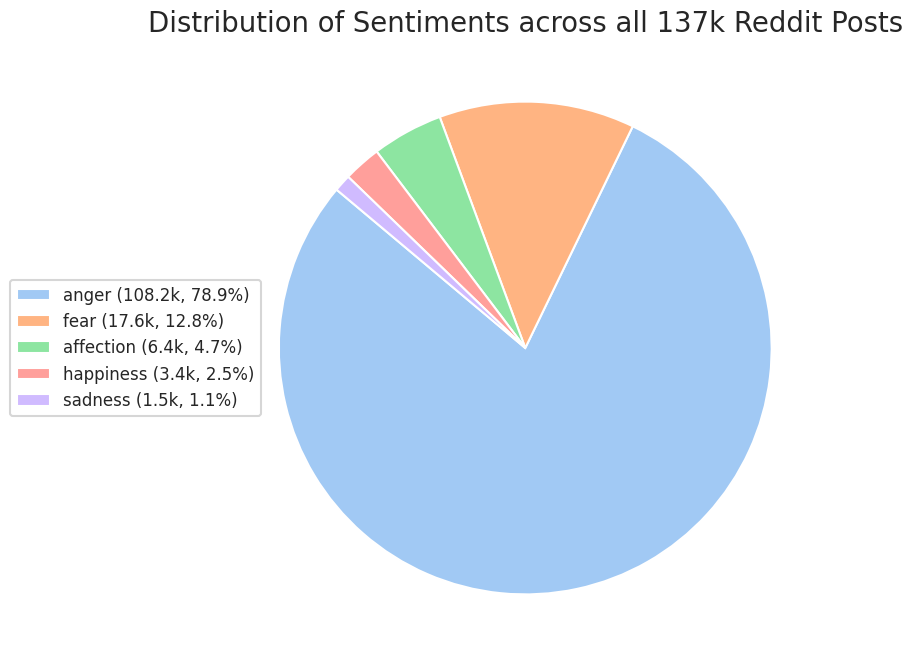

In [10]:
sentiment_counts = pd.Series(sentiment_counts)

# use counts to set labels, slice sizes and colors
labels = sentiment_counts.index
sizes = sentiment_counts.values
colors = sns.color_palette('pastel')

# set figure dimensions and arrange slices
plt.figure(figsize=(10, 8))
wedges, texts = plt.pie(
    sizes, labels=None, startangle=140, colors=colors)[:2]

# hide the percetanges on the pie chart as those on the smaller slices overlap
for text in texts:
    text.set_visible(False)

# compute rounded percentages per slice for a legend
percentages = [f'{size/sum(sizes)*100:.1f}%' for size in sizes]

# create legend that displays emotion/sentiment, number of posts and percentage
plt.legend(wedges, [f'{label} ({size/1000:.1f}k, {pct})' for label, size, pct in zip(labels, sizes, percentages)],
           loc='center left', bbox_to_anchor=(-0.35, 0.5), fontsize=12)
# add title
plt.title('Distribution of Sentiments across all 137k Reddit Posts')

plt.savefig("sentiment_shares_leia.png", bbox_inches='tight')

plt.show()

In [11]:
print(data['sentiment'].unique())

['anger' 'happiness' 'fear' 'sadness' 'affection' nan]


In [12]:
# set sentiment mapping
sentiment_mapping = {'anger': 0, 'happiness': 1, 'fear': 2, 'sadness': 3, 'affection': 4}

# and use sentiment mapping to create new column with mapped sentiment numbers for plotting
data['sentiment_num'] = data['sentiment'].map(sentiment_mapping)

In [13]:
# adjust colour palette for visibility
palette = sns.color_palette("husl", n_colors=len(sentiment_mapping))
# swap first two colours, as otherwise anger and affection are too similar
palette[0], palette[4] = palette[4], palette[0]

# set custom colour map
cmap = mcolors.ListedColormap(palette)

And inspect the normalized LEIA predicted VAD scores: 

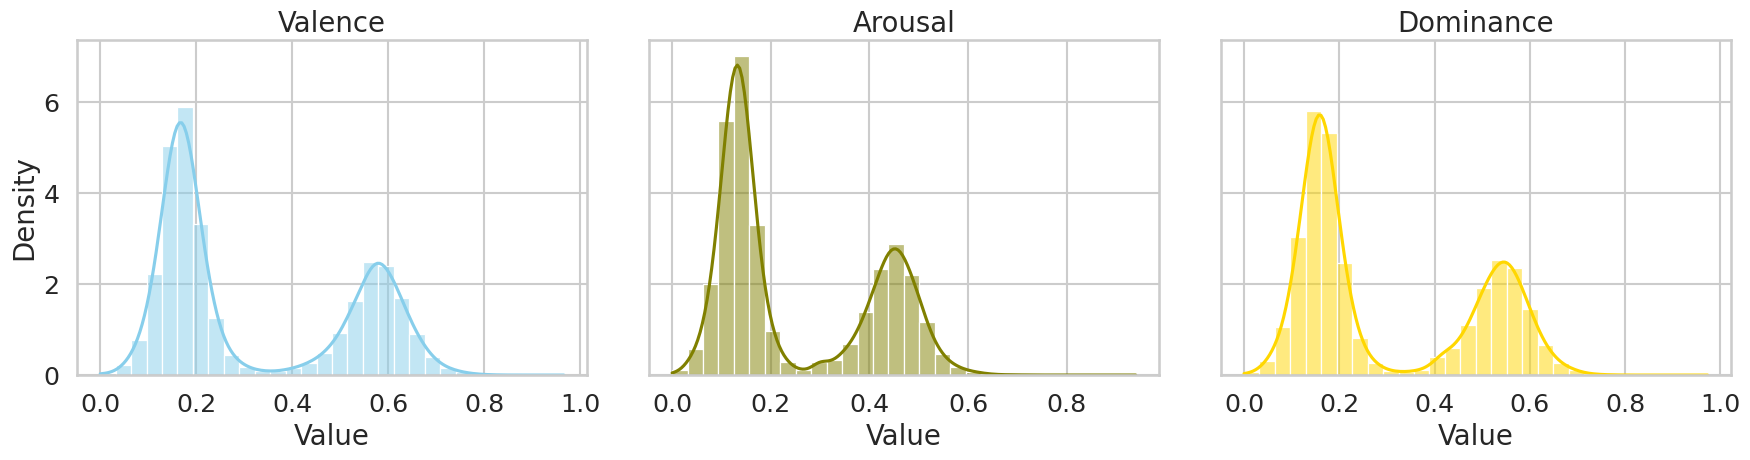

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# surpress filter warning by seaborn
warnings.filterwarnings("ignore", category=FutureWarning, message=".*use_inf_as_na.*")

# density plot for author Valence
sns.histplot(data['Valence'], kde=True, stat="density", color="skyblue", bins=30, ax=axes[0])
axes[0].set_title('Valence')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Density')

# density plot for author Arousal
sns.histplot(data['Arousal'], kde=True, stat="density", color="olive", bins=30, ax=axes[1])
axes[1].set_title('Arousal')
axes[1].set_xlabel('Value')

# density plot for author valence
sns.histplot(data['Dominance'], kde=True, stat="density", color="gold", bins=30, ax=axes[2])
axes[2].set_title('Dominance')
axes[2].set_xlabel('Value')

# add title
#plt.title('Density Plots for NRC-VAD Scores')

plt.savefig("density_nrc_vad.png", bbox_inches='tight')

# set layout
plt.tight_layout()
plt.show()

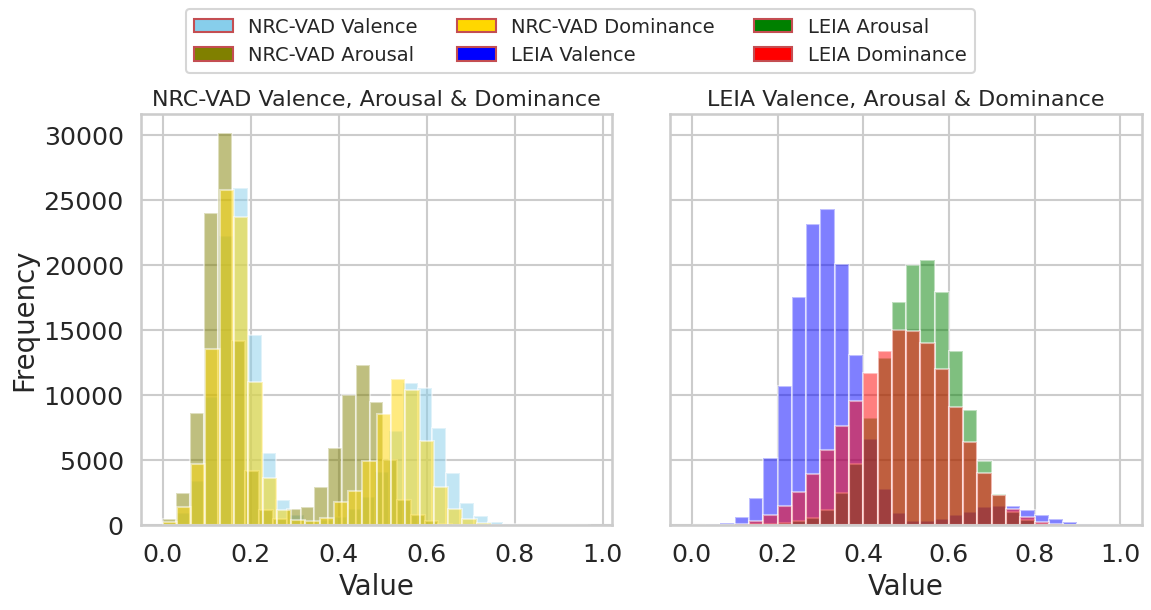

In [15]:
# set dimensions of the subplot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# set left subplot for authors' VAD distributions
ax1.hist(data['Valence'], bins=30, alpha=0.5, label='Valence', color='skyblue')
ax1.hist(data['Arousal'], bins=30, alpha=0.5, label='Arousal', color='olive')
ax1.hist(data['Dominance'], bins=30, alpha=0.5, label='Dominance', color='gold')
ax1.set_xlabel('Value')
ax1.set_ylabel('Frequency')
ax1.set_title('NRC-VAD Valence, Arousal & Dominance', fontsize=16)

# set right subplot for LEIA VAD distributions
ax2.hist(data['nd_valence'], bins=30, alpha=0.5, label='Valence', color='blue')
ax2.hist(data['nd_arousal'], bins=30, alpha=0.5, label='Arousal', color='green')
ax2.hist(data['nd_dominance'], bins=30, alpha=0.5, label='Dominance', color='red')
ax2.set_xlabel('Value')
ax2.set_title('LEIA Valence, Arousal & Dominance', fontsize=16)

# set legend elements to address different data sources
legend_elements = [
    Patch(facecolor='skyblue', edgecolor='r', label='NRC-VAD Valence'),
    Patch(facecolor='olive', edgecolor='r', label='NRC-VAD Arousal'),
    Patch(facecolor='gold', edgecolor='r', label='NRC-VAD Dominance'),
    Patch(facecolor='blue', edgecolor='r', label='LEIA Valence'),
    Patch(facecolor='green', edgecolor='r', label='LEIA Arousal'),
    Patch(facecolor='red', edgecolor='r', label='LEIA Dominance')
]

# include shared legend and make sure it does not overlap with title
fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=3, fontsize=14, markerscale=0.8)

# adjust overall layout to set legend
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("VAD_frequency_comparison.png", bbox_inches='tight')

plt.show()

# Text Complexity and Sentiment

Let's visualize the distribution of Type-Token-Ratio against Gunning-Fog for the different 5 sentiments as mapped by LEIA and additionally colour every point based on its probability of being considered toxic.

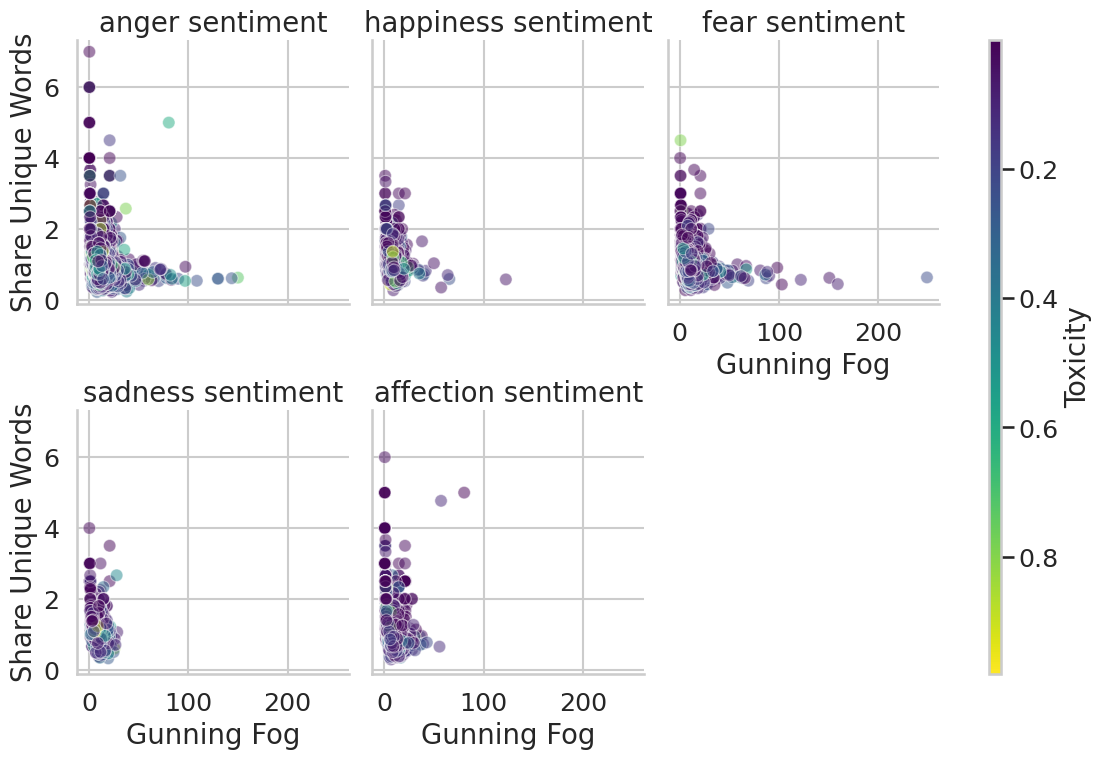

In [16]:
# set colormap for consistency and norm viridis pattern over all toxicity probs
cmap =  plt.colormaps.get_cmap('viridis')
norm = mcolors.Normalize(vmin=data['toxicity'].min(), vmax=data['toxicity'].max())

# use seaborn for facetgrid and 
g = sns.FacetGrid(data, col="sentiment", col_wrap=3, height=4, aspect=1)
g.map_dataframe(sns.scatterplot, x="Gunning_Fog", y="share_unique words", hue="toxicity", palette=cmap, alpha=0.5)

# add and adjust labels 
g.set_titles(col_template="{col_name} sentiment")
g.set_axis_labels("Gunning Fog", "Share Unique Words")

# create toxicity-legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Only needed for older Matplotlib versions

# set toxicity-legend as a vertical bar that displays the colourmap
cbar = g.fig.colorbar(sm, ax=g.axes, orientation='vertical', pad=0.01, aspect=50)
cbar.set_label('Toxicity')
cbar.ax.invert_yaxis()

# adjust layout to make room for toxicity-legend
g.fig.subplots_adjust(right=0.8, hspace=0.4)

plt.savefig('text_complexity_against_sentiment_toxicity.png', bbox_inches='tight')

plt.show()

The colourmapping shows the same right-skewed distribution of toxicity probability as in the toxicity-analysis. It is not surprising that most texts are not considered to be toxic; however, the categories 'anger' and 'happiness' display a few data points that are more brightly coloured, indicating a higher toxicity probability. This might go along with the theory of benevolent sexism expressed via Valence/positive sentiments and negative sentiments/Dominance expressed in the anger sentiment.   

## Compare NRC-VAD and LEIA Predictions

In [17]:
# set author predictions and LEIA predictions as variable-pairs

difference_pairs = [
    ('Valence', 'nd_valence'),
    ('Arousal', 'nd_arousal'),
    ('Dominance', 'nd_dominance')
]

In [18]:
# intiialze an empty list for results
pair_differences = []

# iteratre over both columns per pair and obtain differences
for col1, col2 in difference_pairs:
    differences = data[col1] - data[col2]
    # compute mean over all differences
    mean_diff = np.mean(differences)
    # and standard deviation
    std_diff = np.std(differences)
    # append to list
    pair_differences.append((f'{col1} vs {col2}', mean_diff, std_diff))

In [19]:
# convert pair_differences to dataframe for plotting / analysis
pair_differences_df = pd.DataFrame(pair_differences, columns=['vad_pair', 'mean_level_difference', 'stan_deviation'])

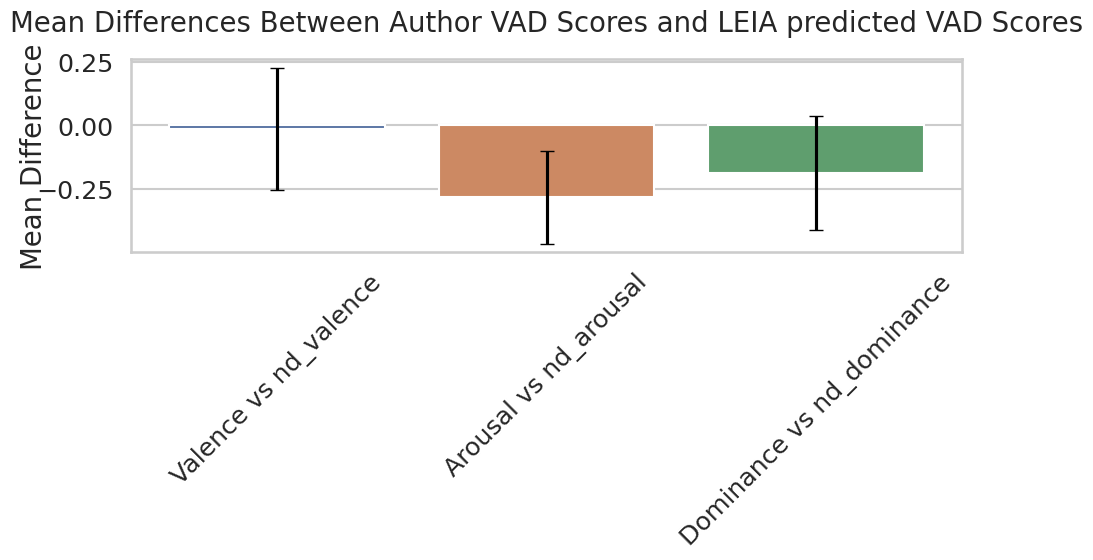

In [20]:
# visualize the differences across pairs
plt.figure(figsize=(10, 6))
sns.barplot(x='vad_pair', y='mean_level_difference', data=pair_differences_df, errorbar=None)

# include error bars using pre-computed standard deviation
for i, row in pair_differences_df.iterrows():
    plt.errorbar(row['vad_pair'], row['mean_level_difference'], yerr=row['stan_deviation'], fmt='none', c='black', capsize=5)

# add extra padding to title to make sure title and plot do not overlap
plt.title('Mean Differences Between Author VAD Scores and LEIA predicted VAD Scores', pad=20)

# set coordinates of y-label so that it does not overlap with title
plt.gca().yaxis.set_label_coords(-0.1, 0.2)
plt.gca().set_ylabel('Mean Difference')

# set empty x-axis label as vad pairs will be plotted
plt.xlabel('') 
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('mean_differences_vad_scores.png', bbox_inches='tight')

plt.show()

The differences are apparent. Where the original dominance scores are close to the new LEIA predictions, the arousal scores differ greatly and the LEIA results tend to report lower scores than the NRC-VAD lexicon. The most prominent difference lies in the valence prediction, where LEIA appears to overestimate (?) the NRC-VAD results. 

## Visualize VAD Dimensionality

Given the original mapping of the VAD scores to Sentiments, I visualized the LEIA sentiments in a 3D environment to assess how successful our mapping is. This sub-analysis consists of 3 plots, where every data point is coloured by a sentiment mapping and then:

- first, plots the data points against the authors' NRC-VAD Scores
- second, plots the data points against the direct sentiment mapping by XXXX
- third, plots the data points against our version of the above mapping, considering the standard deviation provided as an additional uncertainty level

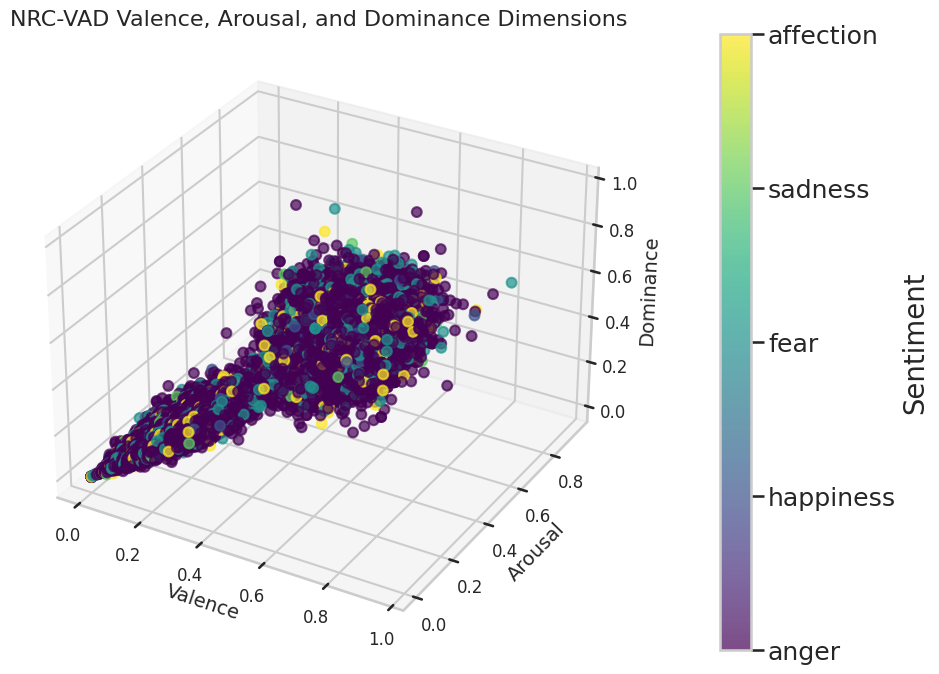

In [21]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# create scatter plots
scatter = ax.scatter(
    data['Valence'], 
    data['Arousal'], 
    data['Dominance'], 
    # color each data point by sentiment
    c=data['sentiment_num'],
    cmap='viridis',       
    # set first size of marker and second the transparency
    s=50,
    alpha=0.7
)

# set font size so that labels do not overlap
ax.set_xlabel('Valence', fontsize=14)
ax.set_ylabel('Arousal', fontsize=14)
ax.set_zlabel('Dominance', fontsize=14)
ax.set_title('NRC-VAD Valence, Arousal, and Dominance Dimensions', fontsize=16)

# adjust label placement slightly to avoid overlap
ax.tick_params(axis='both', which='major', labelsize=12)

# create colourbar that matches sentiment-value to colourmap
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Sentiment')
cbar.set_ticks(list(sentiment_mapping.values()))
cbar.set_ticklabels(list(sentiment_mapping.keys()))

plt.savefig('NRC_VAD-Dimensions_3d.png', bbox_inches='tight')
plt.show()

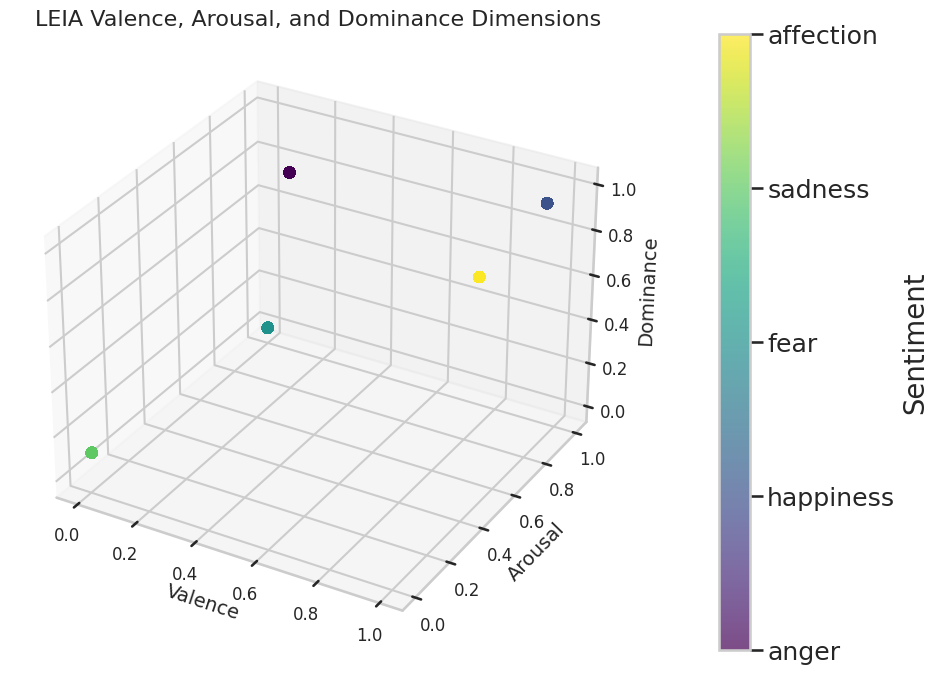

In [22]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# create scatter plots
scatter = ax.scatter(
    data['valence'], 
    data['arousal'], 
    data['dominance'], 
    # color each data point by sentiment
    c=data['sentiment_num'],
    cmap='viridis',       
    # set first size of marker and second the transparency
    s=50,
    alpha=0.7
)

# set font size so that labels do not overlap
ax.set_xlabel('Valence', fontsize=14)
ax.set_ylabel('Arousal', fontsize=14)
ax.set_zlabel('Dominance', fontsize=14)
ax.set_title('LEIA Valence, Arousal, and Dominance Dimensions', fontsize=16)

# adjust label placement slightly to avoid overlap
ax.tick_params(axis='both', which='major', labelsize=12)

# create colourbar that matches sentiment-value to colourmap
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Sentiment')
cbar.set_ticks(list(sentiment_mapping.values()))
cbar.set_ticklabels(list(sentiment_mapping.keys()))

plt.savefig('LEIA-Dimensions_3d_direct_mapping.png', bbox_inches='tight')
plt.show()

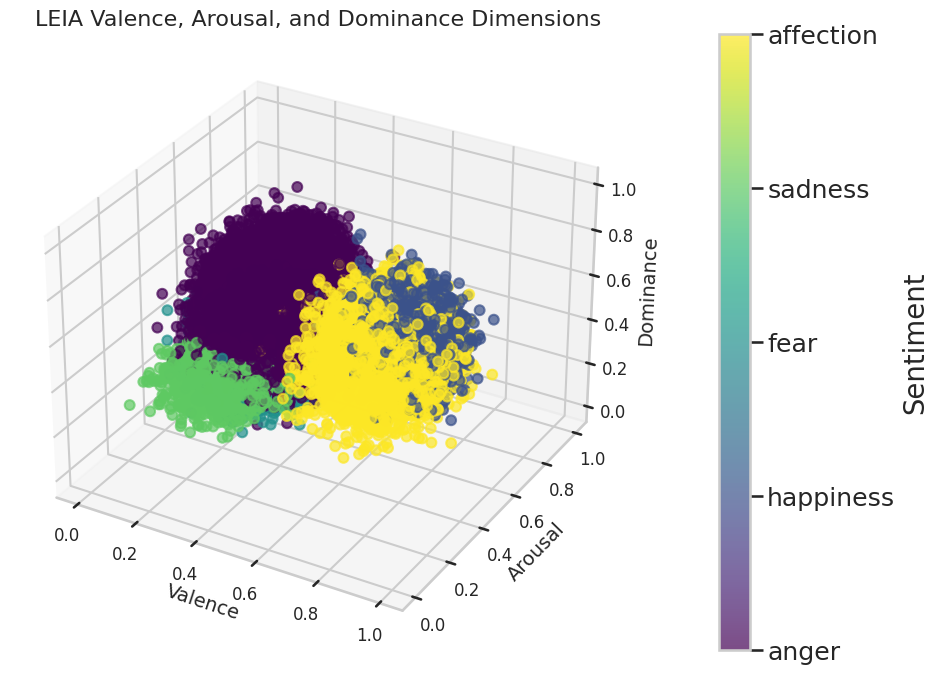

In [23]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    data['nd_valence'], 
    data['nd_arousal'], 
    data['nd_dominance'], 
    # color each data point by sentiment
    c=data['sentiment_num'],
    cmap='viridis',       
    # set first size of marker and second the transparency
    s=50,
    alpha=0.7
)

# set font size so that labels do not overlap
ax.set_xlabel('Valence', fontsize=14)
ax.set_ylabel('Arousal', fontsize=14)
ax.set_zlabel('Dominance', fontsize=14)
ax.set_title('LEIA Valence, Arousal, and Dominance Dimensions', fontsize=16)

# adjust label placement slightly to avoid overlap
ax.tick_params(axis='both', which='major', labelsize=12)

# create colourbar that matches sentiment-value to colourmap
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Sentiment')
cbar.set_ticks(list(sentiment_mapping.values()))
cbar.set_ticklabels(list(sentiment_mapping.keys()))


plt.savefig('LEIA-Dimensions_3d_normed.png', bbox_inches='tight')
plt.show()

# Correlation Analysis

We are evalutating the following three hypotheses using heatmaps for analysis:

**Hypotheses:**

- **H1:** Sentimentally gender biased (VAD) Reddit posts about or directed at female US politicians display lower text complexity.
- **H2:** Toxic Reddit posts about or directed at female US politicians display lower text complexity.
- **H3:** Sentimental gender bias operationalized through toxicity and sentimental gender bias operationalized through VAD correlate positively.


## Inspection of Correlations for Author VAD scores and Gunning-Fog and Type-Token-Ratio

In [24]:
# make sure data type is numeric:
numeric_columns = [
    'nr_sentences', 'nr_words', 'nr_characters', 'nr_letters',
    'nr_syllables', 'nr_words_one_syllable', 'nr_unique_words',
    'share_unique words', 'nr_swear_words', 'share_swear_words',
    'nr_words_more_syllables', 'Gunning_Fog'
]

for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

In [25]:
# compute correlation matrix over selection of text features, complexity indicators and VAD scores
corr_matrix_GF = data[['nr_sentences', 'nr_words', 'nr_syllables', 'share_unique words', 'share_swear_words', 'Valence', 'Arousal', 'Dominance', 'gender_dummy', 'Gunning_Fog', 'toxicity']].corr()

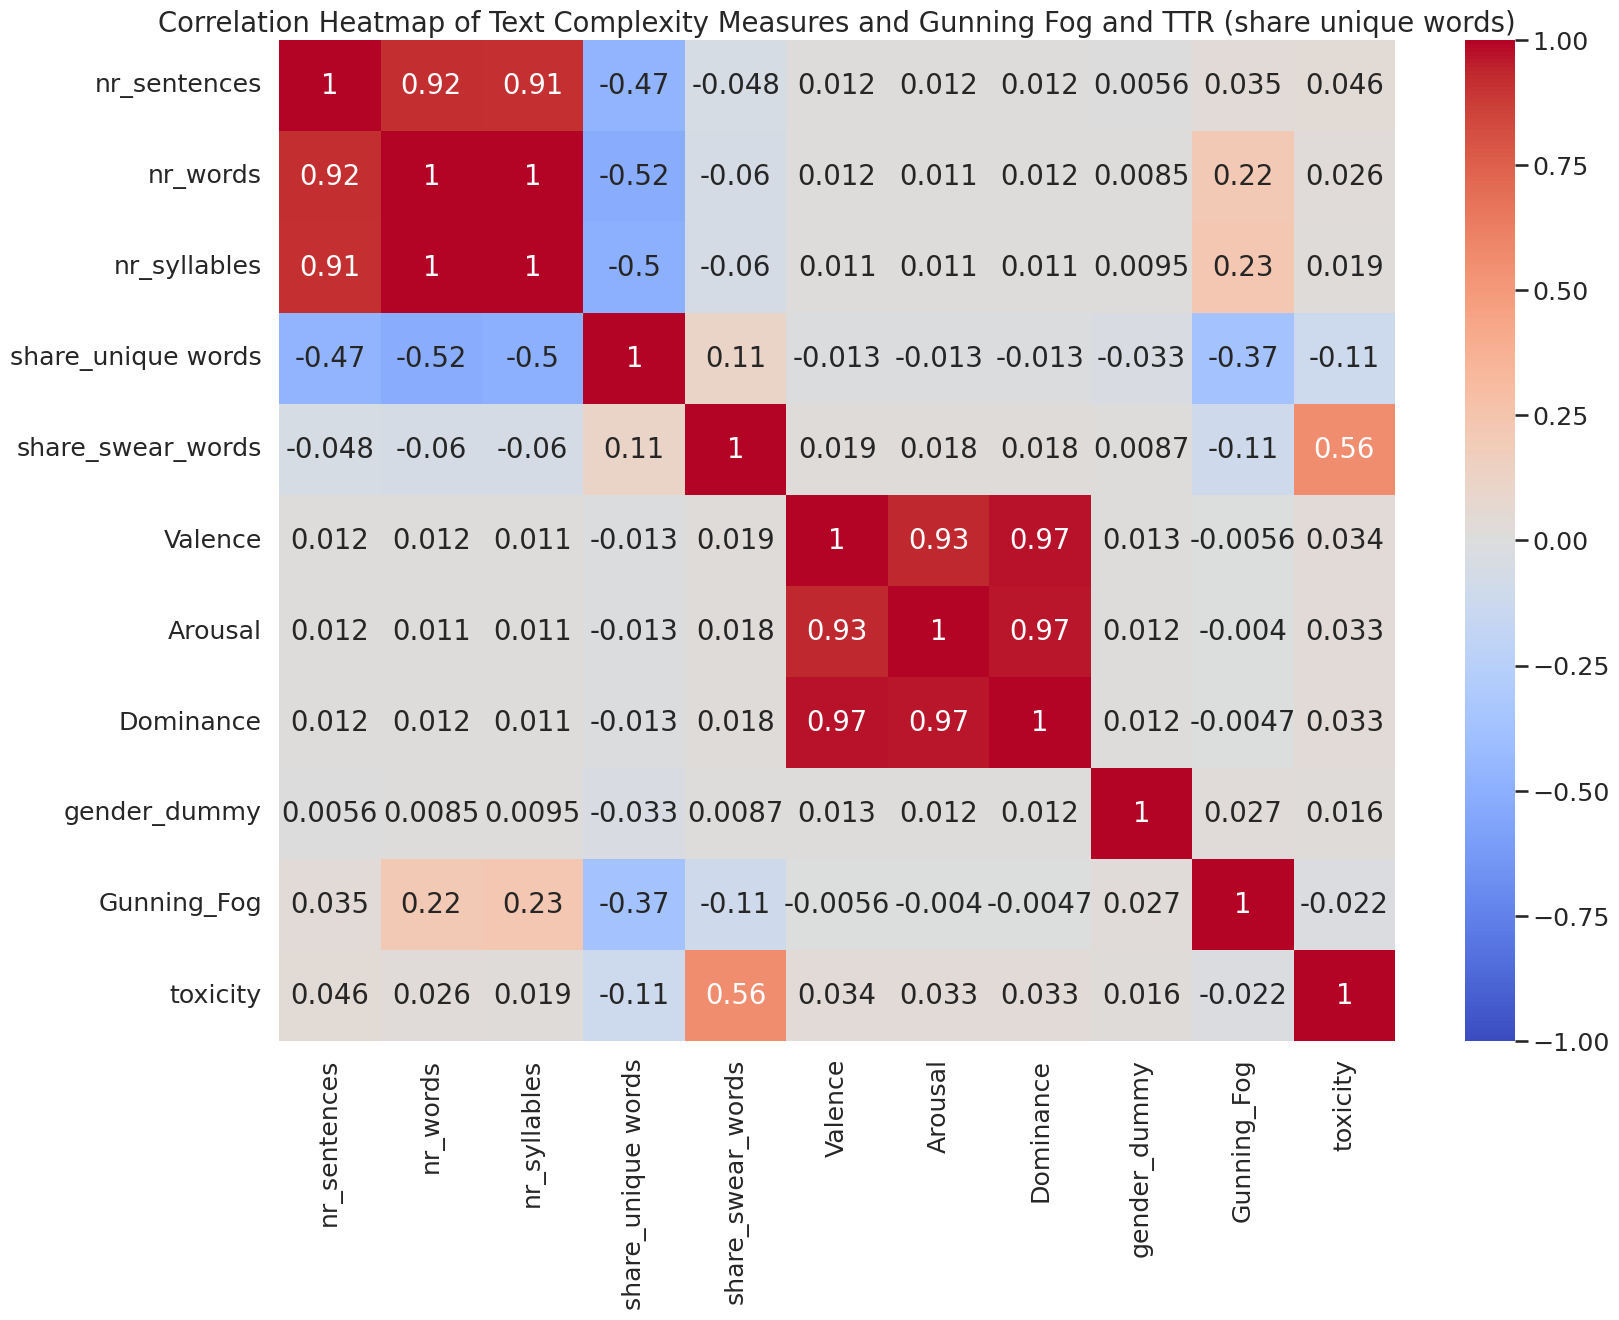

In [26]:
# layout of heatmap for GF

# set image size
plt.figure(figsize=(18, 13))

# use seaborn for heatmap
sns.heatmap(corr_matrix_GF, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

# set title and show
plt.title('Correlation Heatmap of Text Complexity Measures and Gunning Fog and TTR (share unique words)')

plt.savefig('Heatmap_complexity_author_nrc_vad.png', bbox_inches='tight')
plt.show()

## Heatmap for LEIA predicted Sentiments and Text Complexity

First, let's inspect the LEIA results next to Gunning-Fog and Type-Token-Ratio.

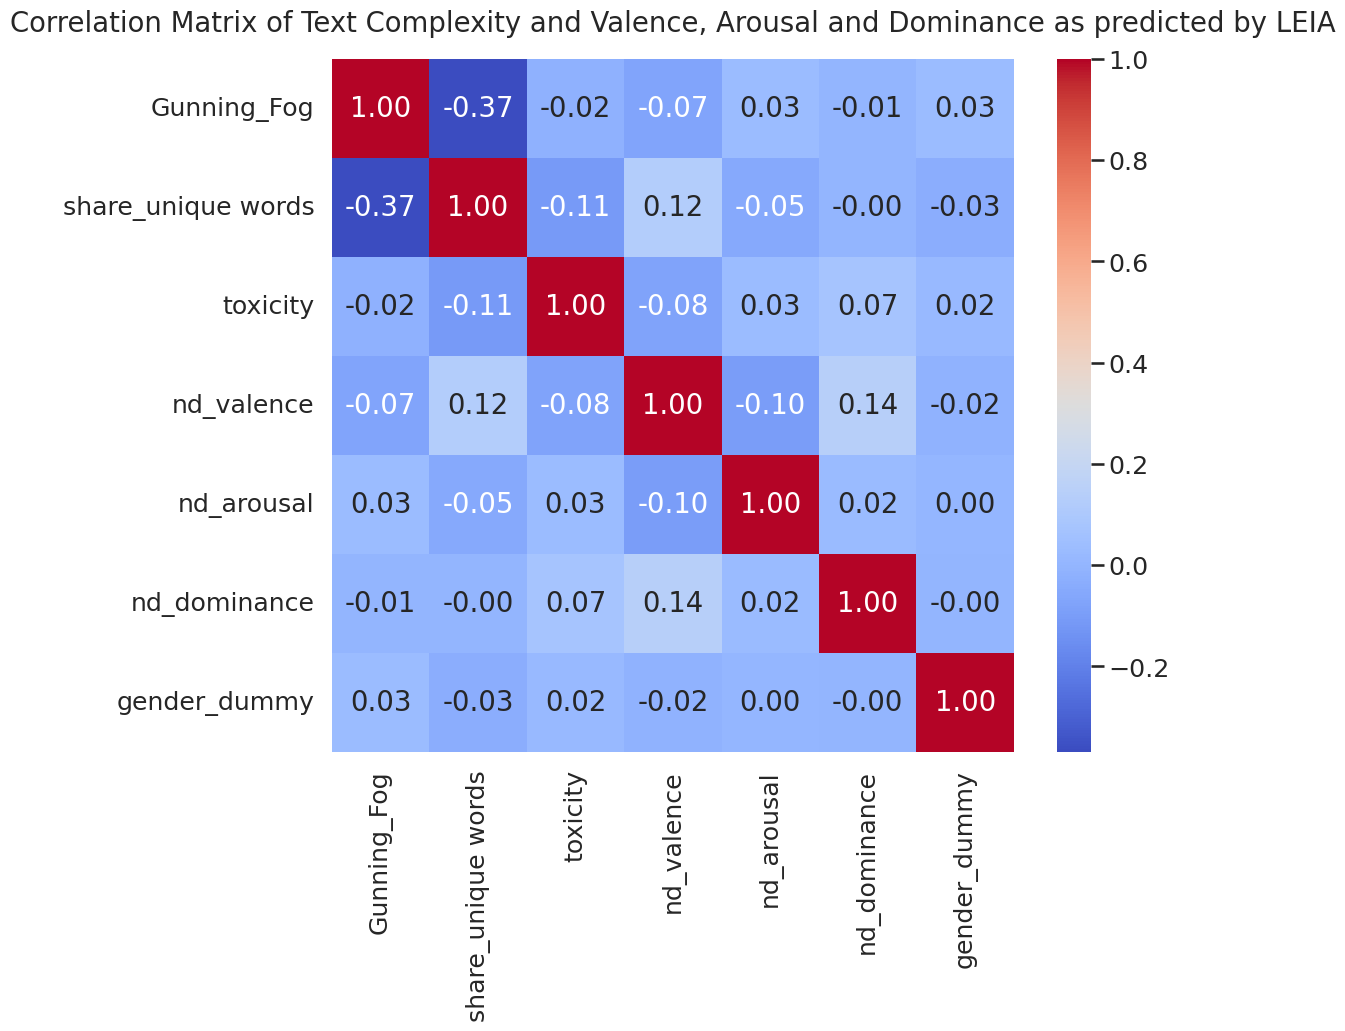

In [27]:
# assess correlations between VAD and Gunning-Fog
correlation_matrix = data[['Gunning_Fog', 'share_unique words','toxicity', 'nd_valence', 'nd_arousal', 'nd_dominance', 'gender_dummy']].corr()

plt.figure(figsize=(11, 9))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
# add additional padding to title to make sure it does not overlap with heatmap
plt.title('Correlation Matrix of Text Complexity and Valence, Arousal and Dominance as predicted by LEIA', pad=20)

plt.savefig("correlation_analysis_heatmap_presentation.png", bbox_inches='tight')
plt.show()

Second, let's include the author's scores into the heatmap.

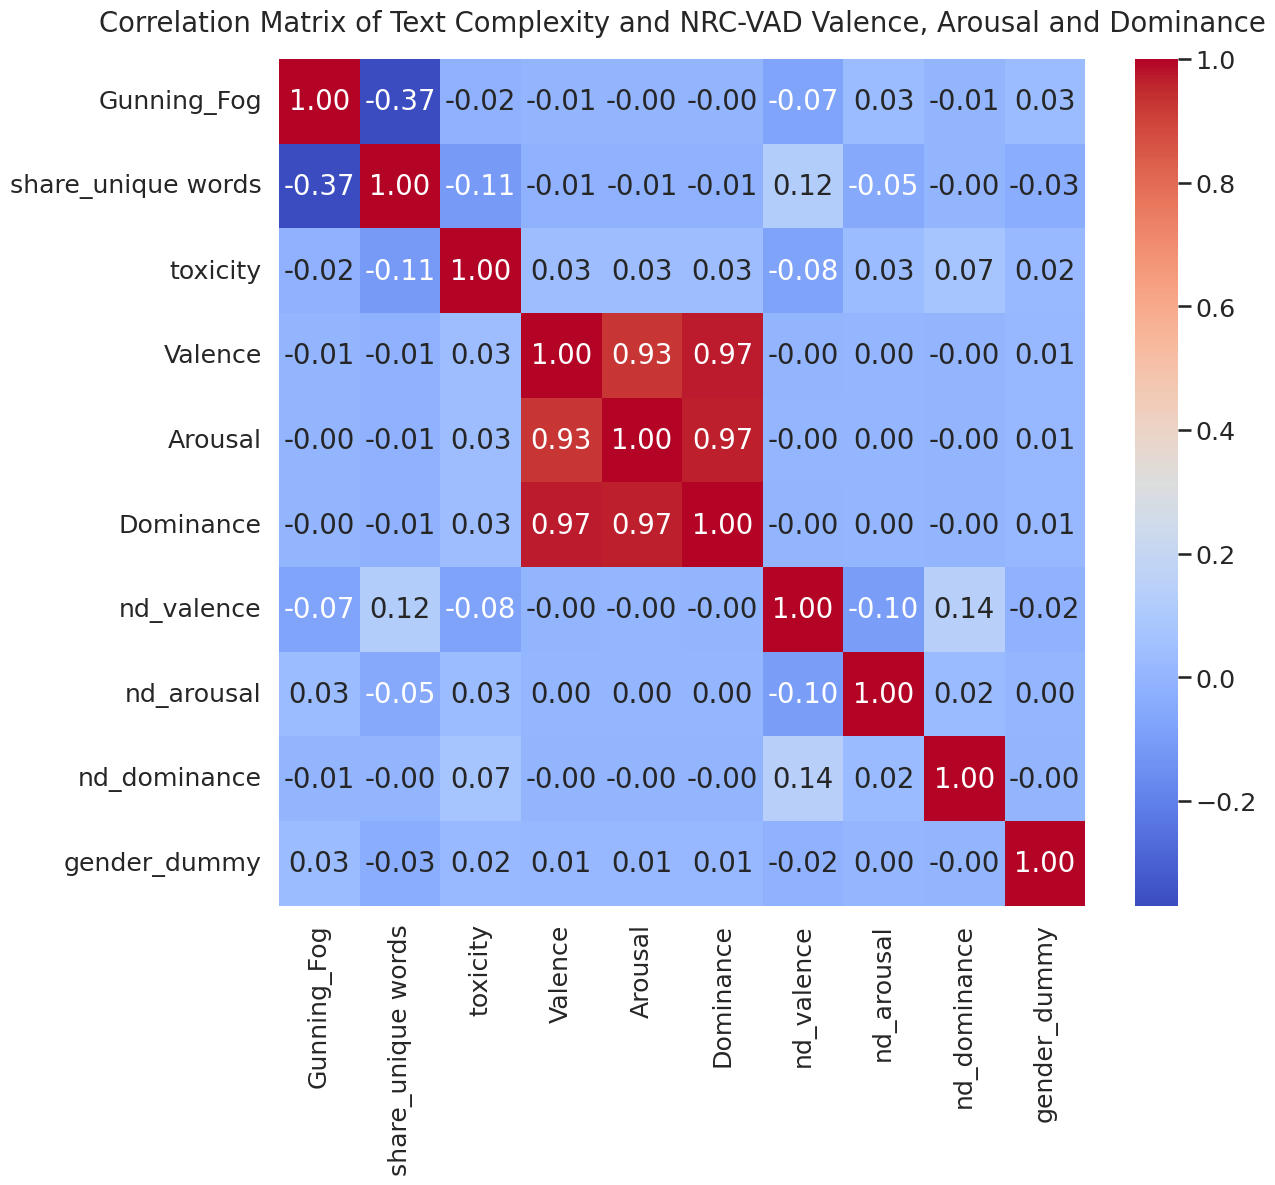

In [28]:
# try out the same thing with author VAD scores:

# assess correlations between VAD and Gunning-Fog
correlation_matrix = data[['Gunning_Fog', 'share_unique words', 'toxicity', 'Valence', 'Arousal', 'Dominance', 'nd_valence', 'nd_arousal', 'nd_dominance', 'gender_dummy']].corr()

plt.figure(figsize=(13, 11))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
# add additional padding to title to make sure it does not overlap with heatmap
plt.title('Correlation Matrix of Text Complexity and NRC-VAD Valence, Arousal and Dominance', pad=20)

plt.savefig("correlation_comparison_heatmap_report.png", bbox_inches='tight')
plt.show()

# Further Descriptive Analysis

## Inspect Type Token Ratio and Gunning-Fog and Toxicity

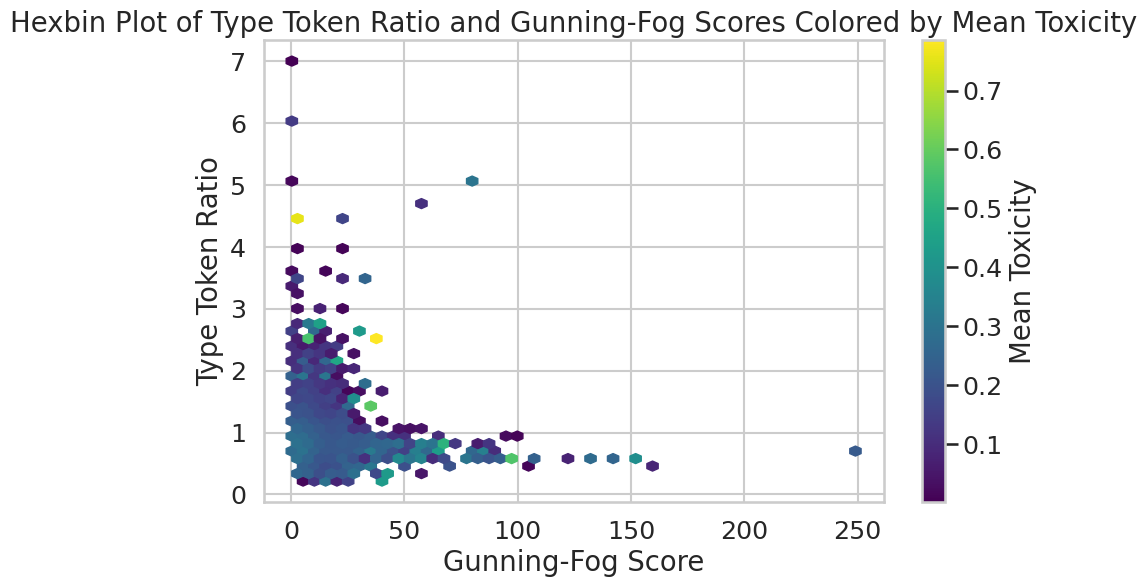

In [29]:
plt.figure(figsize=(10, 6))
# use hexbin plot to indicate 
hb = plt.hexbin(data['Gunning_Fog'], data['share_unique words'], C=data['toxicity'], gridsize=50, cmap='viridis', reduce_C_function=np.mean)

# add colourbar to indicate the probability of a text to be toxic
cbar = plt.colorbar(hb)
cbar.set_label('Mean Toxicity')

# add labels and title
plt.xlabel('Gunning-Fog Score')
plt.ylabel('Type Token Ratio')
plt.title('Hexbin Plot of Type Token Ratio and Gunning-Fog Scores Colored by Mean Toxicity')

plt.savefig('hexbin_type_token_ratio_gunning_fog_toxicity.png', bbox_inches='tight')

plt.show()

# Cluster Analysis

Due to the descriptive aspect of our main analysis, we provide a basic clustering of the reddit posts based on serveral metrics assing the posts' textual bodys as well as the gender of the targeted people and subreddit and LEIA sentiment.

In [30]:
# seperate into numerical and cateogrical features
numerical_features = ['nr_sentences', 'nr_words', 'nr_characters', 'nr_letters', 'nr_syllables', 'nr_words_one_syllable',
                      'nr_unique_words', 'share_unique words', 'nr_swear_words', 'share_swear_words', 'nr_words_more_syllables', 'Gunning_Fog', 'toxicity']
categorical_features = ['subreddit', 'gender_dummy', 'sentiment']

In [31]:
# initialize preprocessor for both numerical and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(categories='auto', handle_unknown='ignore'), categorical_features)
    ])

# and pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('kmeans', KMeans(n_clusters=5, random_state=42))])

In [32]:
# create dataframe just for cluster analysis using the preselected features
selected_df = data[numerical_features + categorical_features]

In [33]:
# drop any missing values as k-means relies on a complete dataset
selected_df = selected_df.dropna()

# check if any columns still include Nas
missing_values = selected_df.isnull().sum()
print("Missing values in each column:")
print(missing_values[missing_values > 0])

Missing values in each column:
Series([], dtype: int64)


In [34]:
# fit pipeline on preprocessed working dataframe
pipeline.fit(selected_df)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['nr_sentences', 'nr_words',
                                                   'nr_characters',
                                                   'nr_letters', 'nr_syllables',
                                                   'nr_words_one_syllable',
                                                   'nr_unique_words',
                                                   'share_unique words',
                                                   'nr_swear_words',
                                                   'share_swear_words',
                                                   'nr_words_more_syllables',
                                                   'Gunning_Fog', 'toxicity']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['subreddit', 'gender_dummy',
                                                   'sentiment'])])),
                ('kmeans', KMeans(n_clusters=5, random_state=42))])

In [35]:
# and include cluster as new column
selected_df['cluster'] = pipeline.predict(selected_df[numerical_features + categorical_features])

# Visual Inspection of Results

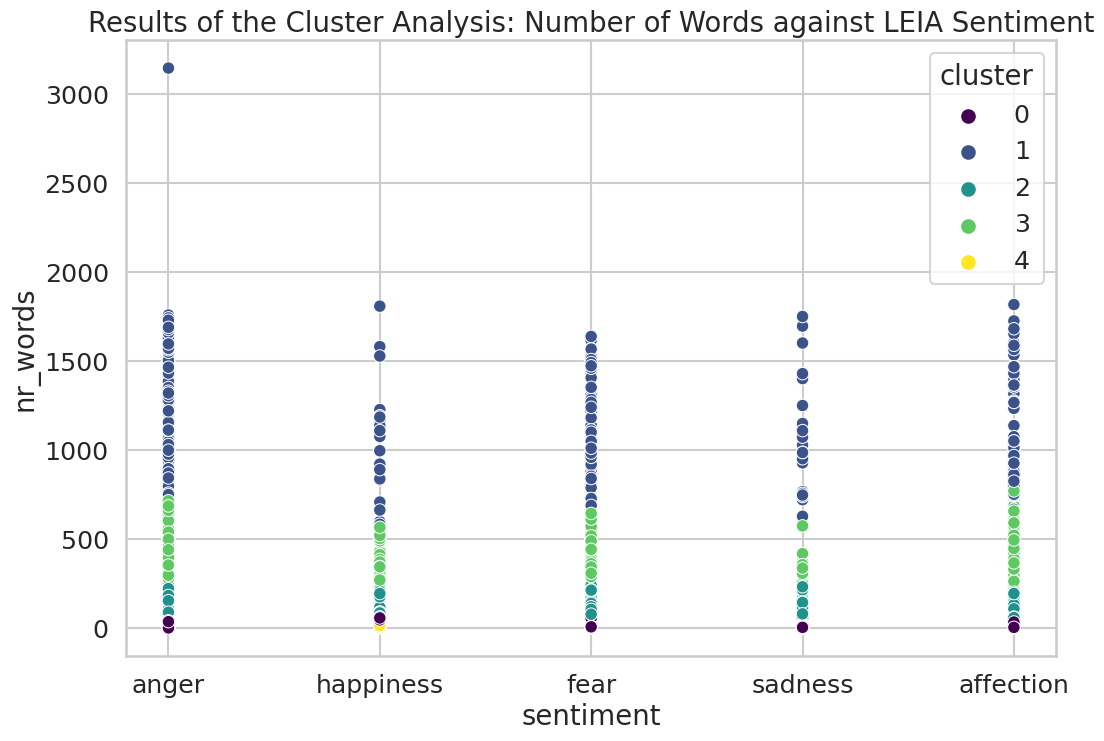

In [36]:
# set plot dimensions
plt.figure(figsize=(12, 8))
sns.scatterplot(data=selected_df, x='sentiment', y='nr_words', hue='cluster', palette='viridis')
plt.title("Results of the Cluster Analysis: Number of Words against LEIA Sentiment")

plt.savefig('Results_clusters_words_against_sentiment.png', bbox_inches='tight')
plt.show()

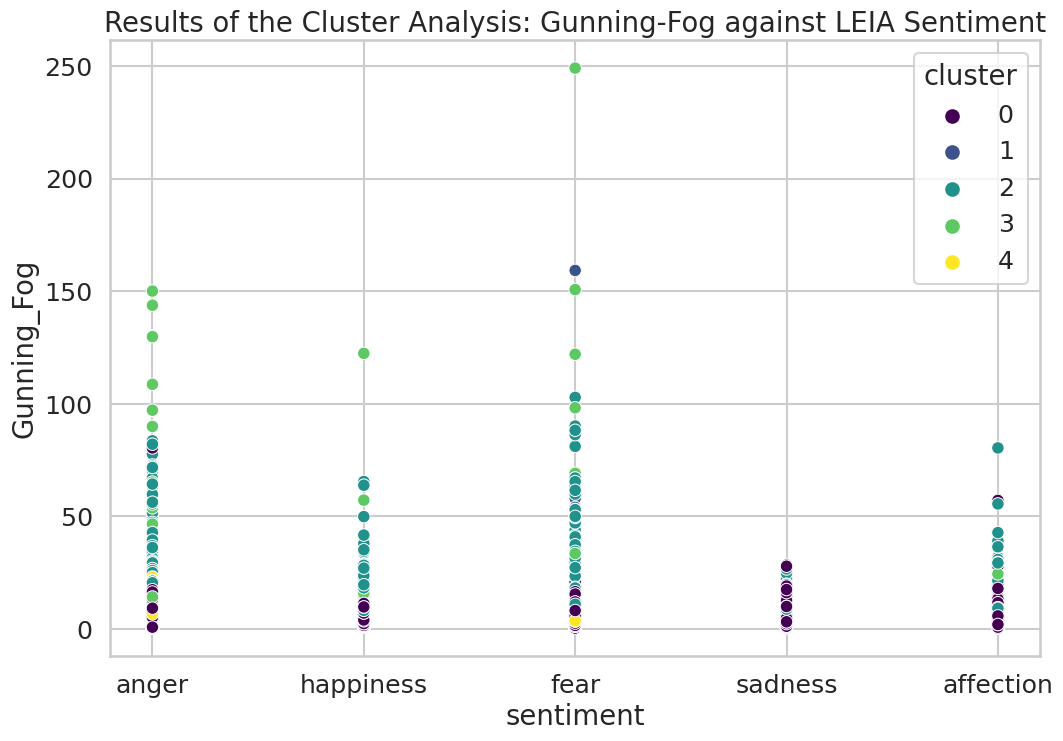

In [37]:
# set plot dimensions
plt.figure(figsize=(12, 8))
sns.scatterplot(data=selected_df, x='sentiment', y='Gunning_Fog', hue='cluster', palette='viridis')
plt.title("Results of the Cluster Analysis: Gunning-Fog against LEIA Sentiment")

plt.savefig('Results_clusters_gunning_fog_against_sentiment.png', bbox_inches='tight')
plt.show()

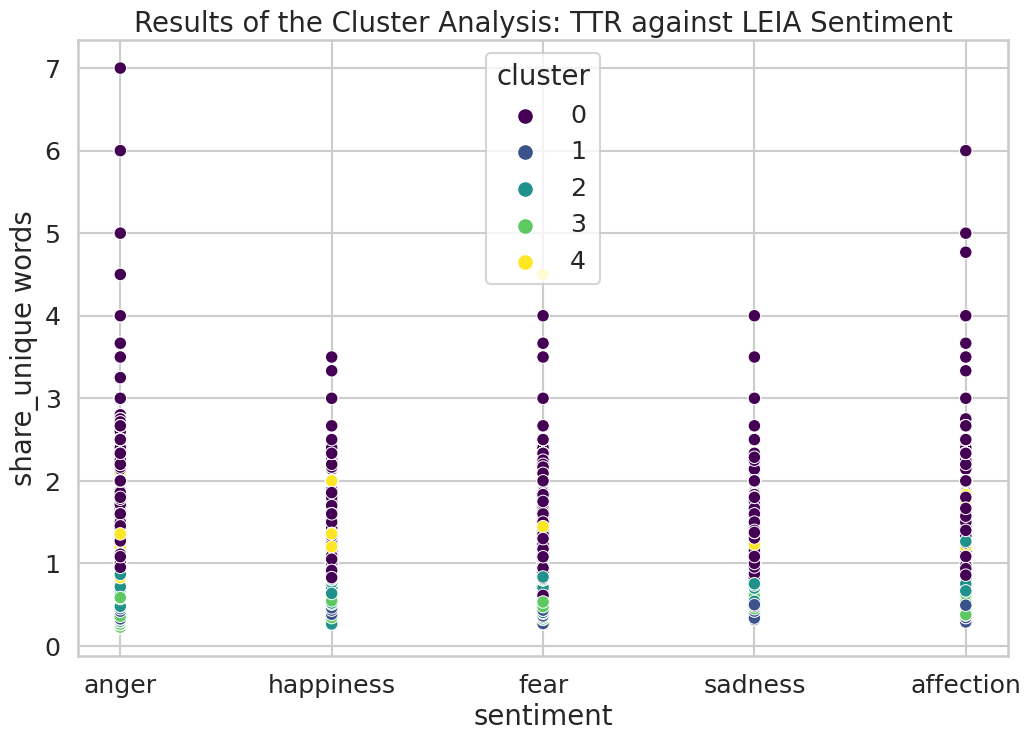

In [38]:
# set plot dimensions
plt.figure(figsize=(12, 8))
sns.scatterplot(data=selected_df, x='sentiment', y='share_unique words', hue='cluster', palette='viridis')
plt.title("Results of the Cluster Analysis: TTR against LEIA Sentiment")

plt.savefig('Results_clusters_toxicity_against_sentiment.png', bbox_inches='tight')

plt.show()

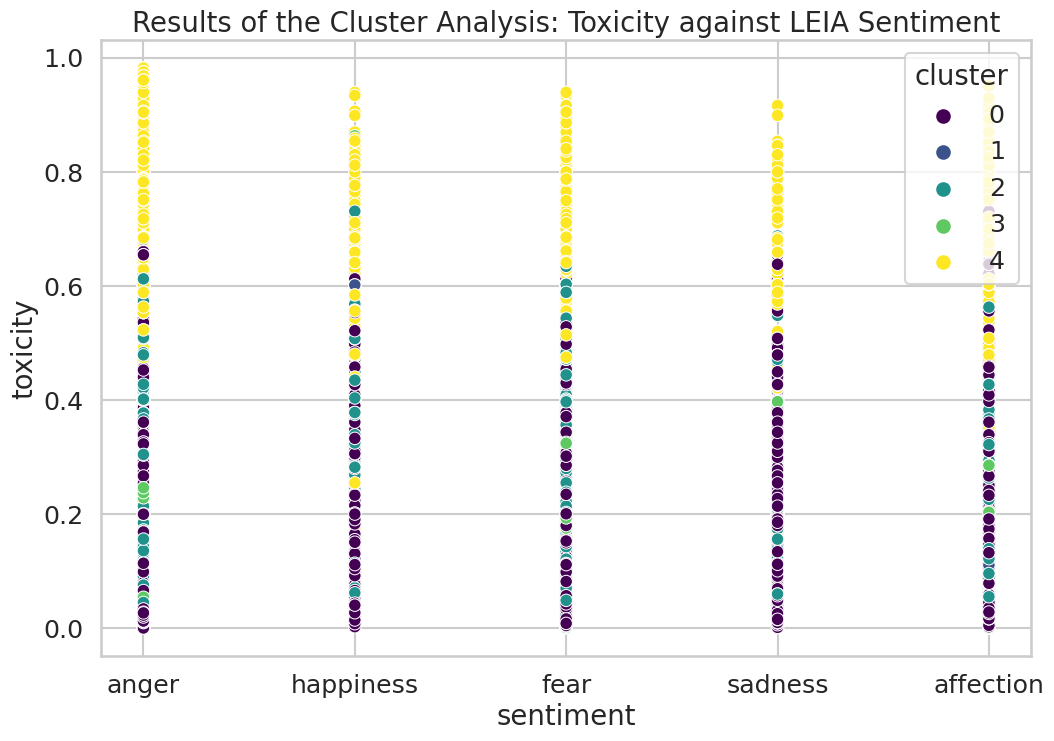

In [39]:
# set plot dimensions
plt.figure(figsize=(12, 8))
sns.scatterplot(data=selected_df, x='sentiment', y='toxicity', hue='cluster', palette='viridis')
plt.title("Results of the Cluster Analysis: Toxicity against LEIA Sentiment")

plt.savefig('Results_clusters_toxicity_against_sentiment.png', bbox_inches='tight')
plt.show()

**Check for differences based on gender or LEIA sentiment prediction using tables**

In [40]:
# and plot clusters against sentiment
cross_tab = pd.crosstab(selected_df['cluster'], data['gender_dummy'])
print(cross_tab)

gender_dummy      1      2
cluster                   
0             10197  63469
1               120    767
2              4712  34466
3               758   5428
4              2047  15057


In [41]:
# and plot clusters against sentiment
cross_tab = pd.crosstab(selected_df['cluster'], data['sentiment'])
print(cross_tab)

sentiment  affection  anger   fear  happiness  sadness
cluster                                               
0               4491  55286  10194       2447     1248
1                 75    621    149         21       21
2               1135  31885   5473        535      150
3                300   5084    713         71       18
4                388  15269   1051        302       94


In [42]:
# compute silhoutte score to assess 'seperateness' of clusters
preprocessed_data = preprocessor.transform(selected_df)
silhouette_avg = silhouette_score(preprocessed_data, selected_df['cluster'])
print(f"The average silhouette score is: {silhouette_avg:.3f}")

The average silhouette score is: 0.258


Given the average silhouette score 0.258, the clusters are only mildly seperate from each other, which is unsurprising given the preprocessing of the original reddit posts. I assume, the differences between clusters migth be due to the length of posts and the imbalances of sentiments (mainly anger).

**Print final cluster descriptions**

In [43]:
# look at numeric columns only to avoid error 
numeric_columns = selected_df.select_dtypes(include=[np.number]).columns

# obtain summary statistics per cluster
cluster_summary = selected_df.groupby('cluster')[numeric_columns].agg(['mean', 'std', 'median', 'min', 'max'])

print(cluster_summary)

        nr_sentences                                   nr_words              \
                mean        std median  min    max         mean         std   
cluster                                                                       
0           2.101227   1.223939    2.0  1.0   17.0    25.820582   15.247995   
1          54.214205  21.701372   49.0  2.0  207.0  1023.652762  290.518485   
2           5.977589   3.205666    5.0  1.0   42.0   106.342922   44.062316   
3          18.391529   8.063268   17.0  1.0   81.0   344.585677  114.578558   
4           2.956735   1.961030    2.0  1.0   21.0    39.126228   27.039708   

                               ... gender_dummy                           \
        median    min     max  ...         mean       std median min max   
cluster                        ...                                         
0         23.0    1.0    82.0  ...     1.861578  0.345345    2.0   1   2   
1        935.0  484.0  3146.0  ...     1.864713  0.342223    2.